In [24]:
import pip

def install(package):
    pip.main(['install', package])

# Example
if __name__ == '__main__':
    install('pydicom')

  Running setup.py bdist_wheel for pydicom: started
  Running setup.py bdist_wheel for pydicom: finished with status 'done'
  Stored in directory: /home/yuliu/.cache/pip/wheels/02/7d/04/871afc63de868b681d69018397c1fb6286af0ae7c0aa5b6e61
Successfully built pydicom


Exception:
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/site-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/pip/commands/install.py", line 342, in run
    prefix=options.prefix_path,
  File "/usr/local/anaconda3/lib/python3.6/site-packages/pip/req/req_set.py", line 784, in install
    **kwargs
  File "/usr/local/anaconda3/lib/python3.6/site-packages/pip/req/req_install.py", line 851, in install
    self.move_wheel_files(self.source_dir, root=root, prefix=prefix)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/pip/req/req_install.py", line 1064, in move_wheel_files
    isolated=self.isolated,
  File "/usr/local/anaconda3/lib/python3.6/site-packages/pip/wheel.py", line 345, in move_wheel_files
    clobber(source, lib_dir, True)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/pip/wheel.py", line 323, in clobber
    shutil.copyfile(srcfile, destf

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from PIL import Image
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage.morphology import binary_dilation,generate_binary_structure
from skimage.morphology import convex_hull_image
from scipy.ndimage.interpolation import zoom
from scipy.io import loadmat
import warnings
from multiprocessing import Pool, cpu_count
from functools import partial


%matplotlib inline


PATH = "/usr/local/kdeploy/Tensorflow/DATA/NLST_trial/217676"

#data_path = "/usr/local/kdeploy/Tensorflow/DATA/NLST_trial/218662"
#PATH = "/usr/local/kdeploy/Tensorflow/DATA/NLST_trial/218662"

output_path = working_path = "/home/yuliu/Documents/"
# Print out the first 5 file names to verify we're in the right folder.

/usr/local/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
patients = os.listdir(PATH)
dicoms = os.listdir(os.path.join(PATH,patients[0]))
patient_0_path = os.path.join(PATH,patients[0])
patient_0_slices = [dicom.read_file(patient_0_path + '/' + s) for s in os.listdir(patient_0_path)]
patient_0_slice = patient_0_slices[0]
patient_0_slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
patient_696_path = os.path.join(PATH,patients[0]) 
patient_696_slices = [dicom.read_file(patient_696_path + '/' + s) for s in os.listdir(patient_696_path)]
patient_696_slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))

sec_num = 2;
while patient_696_slices[0].ImagePositionPatient[2] == patient_696_slices[sec_num].ImagePositionPatient[2]:
    sec_num = sec_num+1;
    
slice_num = int(len(patient_696_slices)/sec_num)
patient_696_slices.sort(key = lambda x: int(x.InstanceNumber))
patient_696_slices = patient_696_slices[:slice_num]
patient_696_slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
patient_0_slice_thickness = np.abs(patient_0_slices[0].ImagePositionPatient[2] - patient_0_slices[1].ImagePositionPatient[2]) 


def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    if slices[0].ImagePositionPatient[2] == slices[1].ImagePositionPatient[2]:
        sec_num = 2;
        while slices[0].ImagePositionPatient[2] == slices[sec_num].ImagePositionPatient[2]:
            sec_num = sec_num+1;
        slice_num = int(len(slices) / sec_num)
        slices.sort(key = lambda x:float(x.InstanceNumber))
        slices = slices[0:slice_num]
        slices.sort(key = lambda x:float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

patient_0_pixel_array = patient_0_slice.pixel_array
    
patient_0_pixel_array

patient_0_slice.RescaleSlope, patient_0_slice.RescaleIntercept

patient_0_pixel_array_hu = patient_0_pixel_array*patient_0_slice.RescaleSlope + patient_0_slice.RescaleIntercept

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16), np.array([slices[0].SliceThickness] + slices[0].PixelSpacing, dtype=np.float32)



In [ ]:
patient_0_image, patient_0_spacing = get_pixels_hu(load_scan(patient_0_path))
spacing = patient_0_spacing
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    #p = measure.block_reduce(p,(3,3,3), func=np.max)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
#plot_3d(patient_0_image, 400)

In [ ]:
plot_3d(patient_0_image, 0)

OK
308
NOW


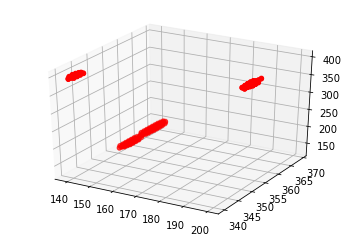

In [5]:
%matplotlib inline
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dir = 'Documents/NC2/Nodule_PNG/'
imfile = '217676.s3.19990102-GE MEDICAL SYSTEMS-1.25-120-STANDARD-80.1.3.6.1.4.1.14519.5.2.1.7009.9004.238276364730046742982927193825.v10.new.png'
#imfile = '218662.s3.19990102-SIEMENS-1-120-B30f-250.1.3.6.1.4.1.14519.5.2.1.7009.9004.125728469265057104905925332880.v12.new.png'
image = dir + imfile

im = misc.imread(image)
im3 = np.reshape(im,(int(im.shape[0]/512),512,im.shape[1]))
nodules3 = np.where(im3==255)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(nodules3[0], nodules3[1], nodules3[2], zdir='z', c= 'red')
plt.savefig("demo.png")
print ("OK")
print(len(im3))
print ("NOW")

In [6]:
#bw3 = patient_0_image & nodules3
plot_3d(patient_0_image & im3, 400)

ValueError: operands could not be broadcast together with shapes (923,512,512) (308,512,512) 